# Seção 09.01 - Support Vector Machines (base crédito)
Para esta seção, usarei a base de dados "credit-data.csv" disponibilizada no curso do Professor Jones na UDEMY.

Motivação: criação dos hiperplanos (convex hulls ou envoltória convexa) que garantem a maior distância entre os conjuntos.

<tr>
    <td>
        <img src="../imagens/svm_artigo.png" alt="SVM" width="300"/>
        <p style="text-align:center">Figura 01 - Exemplo de problema de classificação em 2 dimensões.</p>
        <p style="text-align:center">Fonte: 1995 - Cortes, C.; Vapnik, V.; Support Vector Networks</p>
    </td>
    <td>
        <img src="../imagens/svm_convexHull.png" alt="Convex Hull" width="300"/>
        <p style="text-align:center">Figura 02 - Esquema de duas envoltórias convexas.</p>
        <p style="text-align:center">Fonte: <a href="https://www.semanticscholar.org/paper/A-Fast-Algorithm-of-Convex-Hull-Vertices-Selection-Ding-Nie/4e0f261e36ffeb8fb91da7b184c07fb5cfce3737/figure/0">clique aqui</a>.</p>
    </td>
</tr>

## SVMs não lineares
Para problemas não lineares, usa-se o *kernel trick*.

<img src="../imagens/svm_kernelTrick.jpg" alt="Kernel trick" width="400"/>
<p style="text-align:center">Figura 03 - Esquema do kernel trick.</p>
<p style="text-align:center">Fonte: <a href="https://www.researchgate.net/publication/260283043_Learning_To_Rank_Academic_Experts/figures?lo=1">clique aqui</a>.</p>


<img src="../imagens/svm_kernels.png" alt="Kernels" width="750"/>
<p style="text-align:center">Figura 04 - Kernels mais comuns.</p>
<p style="text-align:center">Fonte: <a href="https://towardsdatascience.com/understanding-support-vector-machine-part-2-kernel-trick-mercers-theorem-e1e6848c6c4d">clique aqui</a>.</p>


In [1]:
# Instruções basiconas de sempre.

# Lidar com dataframes.
import numpy as np
import pandas as pd

# Lidar com gráficos.
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from plotting import (multiple_histograms_plot,
                      bar_plot_with_categorical,
                      plot_confusion_matrix,
                      plot_confusion_matrix_2,
                      plot_roc)

# Lidar com preparação de dados.
from data_prep import data_prep as dp # Eu que fiz esse modulinho ("uuuuuuuuuma bosts!").
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Lidar com validação de modelos.
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
nomeDaBase = "../bases/credit-data.csv"
df = pd.read_csv(nomeDaBase, sep=",", encoding="utf-8")

In [3]:
df.head().T

,0,1,2,3,4
clientid,1.000000,2.000000,3.000000,4.000000,5.000000
income,66155.925095,34415.153966,57317.170063,42709.534201,66952.688845
age,59.017015,48.117153,63.108049,45.751972,18.584336
loan,8106.532131,6564.745018,8020.953296,6103.642260,8770.099235
default,0.000000,0.000000,0.000000,0.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
clientid    2000 non-null int64
income      2000 non-null float64
age         1997 non-null float64
loan        2000 non-null float64
default     2000 non-null int64
dtypes: float64(3), int64(2)
memory usage: 78.2 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
clientid,2000.0,1000.500000,577.494589,1.00000,500.750000,1000.500000,1500.250000,2000.000000
income,2000.0,45331.600018,14326.327119,20014.48947,32796.459717,45789.117313,57791.281668,69995.685578
age,1997.0,40.807559,13.624469,-52.42328,28.990415,41.317159,52.587040,63.971796
loan,2000.0,4444.369695,3045.410024,1.37763,1939.708847,3974.719419,6432.410625,13766.051239
default,2000.0,0.141500,0.348624,0.00000,0.000000,0.000000,0.000000,1.000000


### Problemas encontrados na base:
1. Em "age", há 3 valores nulos e há a presença de valores negativos.

#### OBSERVAÇÃO:

No mundo real, os problemas com as bases são muito piores. Deve-se ter muita atenção pois os dados podem não representar a realidade do processo.

In [6]:
df.loc[df.age < 0, "age"] = df.age.mean()

In [7]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer.fit(df)
df_tratado = pd.DataFrame(data=imputer.transform(df), columns=df.columns)
df_tratado.set_index("clientid", inplace=True)

## 1) Aplicação da Aprendizagem por random forests

### 1.1) Usando *train_test_split*  

In [14]:
# Separando os fatores/previsores da resposta/target:
    
x = df_tratado.iloc[:, 0:-1]
y = df_tratado.iloc[:, -1]

## Escalonamento
Nesse algoritmo é importante executar o escalonamento.

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Aplicando o modelo

In [27]:
from sklearn.svm import SVC

classificador = SVC(kernel='rbf', random_state=0)
classificador.fit(x_train, y_train)
y_pred = classificador.predict(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



### Verificando o como o modelo se saiu

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Métrica 1 (Acurácia): {:.6}.".format(
    accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    classification_report(y_test, y_pred)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    confusion_matrix(y_test, y_pred)))

Métrica 1 (Acurácia): 0.9875.
Métrica 2 (Relatório de classificação):
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       348
         1.0       0.96      0.94      0.95        52

   micro avg       0.99      0.99      0.99       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.99      0.99      0.99       400
.
Métrica 2 (Relatório de classificação):
[[346   2]
 [  3  49]].


Normalized confusion matrix
[[0.99425287 0.00574713]
 [0.05769231 0.94230769]]


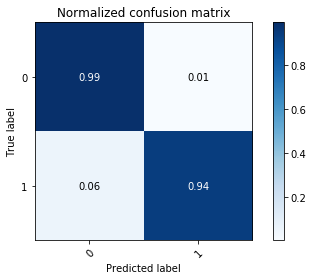

In [29]:
plot_confusion_matrix_2(y_test, y_pred, normalize=True);

### Agora, usando validação cruzada.

In [30]:
classificador.fit(x, y)

resultados = cross_val_score(classificador, x, y, cv = 10)

print("Acurácia média: {:.3} ± {:.3}.".format(resultados.mean(), resultados.std()))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled 

Acurácia média: 0.983 ± 0.00511.
